In [1]:
pip install python-mnist

Note: you may need to restart the kernel to use updated packages.


In this notebook we will use various $AX=B$ solvers and promoted sparsity to define maps that classify the images of the MNIST data set into one of 10 categories, depending on whether the maps believe that a given handwritten image depicts a handwritten digit from 0 to 9. To do this, we use $\texttt{numpy}$, $\texttt{scipy}$, and $\texttt{matplotlib}$. All details are described in the body of the notebook via comments and intermittent Markdown cells. 

In [341]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.optimize import minimize
from scipy.optimize import fmin
from matplotlib import rcParams
rcParams.update({'font.size': 18})

mndata = MNIST('hw1_samples')

images, labels = mndata.load_training()
images2, labels2 = mndata.load_testing()

In [342]:
nsamples = 60000          #set parameters for the data set
ntesting = 10000   
npixels = 784
ndigits = 10

In [343]:
A = np.zeros((nsamples,npixels))     #matrix A will hold all of our training images
for ii in range(nsamples):
    A[ii,:] = images[ii]

B = np.zeros((nsamples,ndigits))     #matrix B will hold training labels
for jj in range(nsamples):
    B[jj,labels[jj]] = 1

In [344]:
C = np.zeros((ntesting,npixels))     #C holds testing images
for ii in range(ntesting):
    C[ii,:] = images2[ii]

D = np.zeros((ntesting,ndigits))     #D holds testing labels
for jj in range(ntesting):
    D[jj,labels2[jj]] = 1

In [345]:
from sklearn import linear_model

In [346]:
Xpinv = np.linalg.pinv(A)@B            #pseudo-inverse

In [347]:
reg = linear_model.LinearRegression()    #vanilla linear regression
reg.fit(A,B)
Xlr = reg.coef_

In [348]:
reg1 = linear_model.Lasso(alpha=0.1)     #Lasso, alpha = 0.1
reg1.fit(A,B)
Xlas1 = reg1.coef_

In [349]:
reg2 = linear_model.Lasso(alpha=0.5)     #Lasso, alpha = 0.5
reg2.fit(A,B)
Xlas2 = reg2.coef_

In [350]:
reg3 = linear_model.Lasso(alpha=1)      #Lasso, alpha = 1.0
reg3.fit(A,B)
Xlas3 = reg3.coef_

In [351]:
regg1 = linear_model.Ridge(alpha=0.1)    #Ridge, alpha = 0.1
regg1.fit(A,B)
Xrid1 = regg1.coef_

In [352]:
regg2 = linear_model.Ridge(alpha=0.5)   #Ridge, alpha = 0.5
regg2.fit(A,B)
Xrid2 = regg2.coef_

Now that we have our matrices $X$ associated to each of the above solvers, we evaluate and compare their error on the test data sets before selecting one and proceeding to cross-validation.

In [353]:
Epinv = np.absolute(D - np.dot(C,Xpinv)); Dpinv = np.dot(C,Xpinv)
Elr = np.absolute(D - np.dot(C,Xlr.T)); Dlr = np.dot(C,Xlr.T)
Elas1 = np.absolute(D - np.dot(C,Xlas1.T)); Dlas1 = np.dot(C,Xlas1.T)    #E[type] contains entrywise absolute error
Elas2 = np.absolute(D - np.dot(C,Xlas2.T)); Dlas2 = np.dot(C,Xlas2.T)    #D[type] is C X[type] (right-multiplied onto C)
Elas3 = np.absolute(D - np.dot(C,Xlas3.T)); Dlas3 = np.dot(C,Xlas3.T)
Erid1 = np.absolute(D - np.dot(C,Xrid1.T)); Drid1 = np.dot(C,Xrid1.T)
Erid2 = np.absolute(D - np.dot(C,Xrid2.T)); Drid2 = np.dot(C,Xrid2.T)

In [354]:
pinv = 0 ; las1 = 0 ; las2 = 0 ; las3 = 0
rid1 = 0 ; rid2 = 0 ; lr = 0

for jj in range(npixels):          #iterate across entries of X[type]
    for ii in range(ndigits):
        if Xpinv[jj,ii] != 0:      #record number of nonzero entries
            pinv = pinv + 1
        if Xlr.T[jj,ii] != 0:
            lr = lr + 1
        if Xlas1.T[jj,ii] != 0:
            las1 = las1 + 1
        if Xlas2.T[jj,ii] != 0:
            las2 = las2 + 1
        if Xlas3.T[jj,ii] != 0:
            las3 = las3 + 1
        if Xrid1.T[jj,ii] != 0:
            rid1 = rid1 + 1
        if Xrid2.T[jj,ii] != 0:
            rid2 = rid2 + 1
nonzero = np.array([[pinv/7840], [lr/7840], [las1/7840], [las2/7840], [las3/7840], [rid1/7840], [rid2/7840]])
print(nonzero)  #nonzero is vector of the fraction of nonzero entries for all of the X[type]

[[0.9821428571428571]
 [0.9821428571428571]
 [0.2880102040816326]
 [0.1531887755102041]
 [0.10625           ]
 [0.9145408163265306]
 [0.9145408163265306]]


In [356]:
pinv = 0 ; las1 = 0 ; las2 = 0 ; las3 = 0
rid1 = 0 ; rid2 = 0 ; lr = 0

for jj in range(ntesting):
    if np.argmax(Dpinv[jj,:]) != np.argmax(D[jj,:]):
        pinv = pinv + 1
    if np.argmax(Dlr[jj,:]) != np.argmax(D[jj,:]):       #record number of times D[type] is most confident of wrong digit
        lr = lr + 1                                      #take the index of max of each row in D[type]
    if np.argmax(Dlas1[jj,:]) != np.argmax(D[jj,:]):     #if this disagrees with index of correct digit in D, count up
        las1 = las1 + 1
    if np.argmax(Dlas2[jj,:]) != np.argmax(D[jj,:]):
        las2 = las2 + 1
    if np.argmax(Dlas3[jj,:]) != np.argmax(D[jj,:]):
        las3 = las3 + 1
    if np.argmax(Drid1[jj,:]) != np.argmax(D[jj,:]):
        rid1 = rid1 + 1
    if np.argmax(Drid2[jj,:]) != np.argmax(D[jj,:]):
        rid2 = rid2 + 1
eratio = np.array([[pinv/ntesting], [lr/ntesting], [las1/ntesting], [las2/ntesting], [las3/ntesting], [rid1/ntesting], [rid2/ntesting]])
print(eratio)       #now eratio is the vector of fractions of errors in this sense in each D[type]

[[0.1466]
 [0.1886]
 [0.1913]
 [0.2083]
 [0.223 ]
 [0.1885]
 [0.1885]]


We choose $\texttt{Xlas2}$ (the middle entry of each of the above 3 output vectors), which is the matrix given by Lasso with $\alpha = 0.5$. The reason for this selection is that while $\texttt{Xlas2}$ maintains a reasonable level of sparsity (only 15% nonzero entries), it still performs with the low error rate of 20%. 

The sparsity of $\texttt{Xlas2}$ can be seen in the plot below; we have the 784 pixels of the images plotted on the $y$-axis, while the spaces on the $x$-axis are the digits to be interpreted. As stated before, we can interpret the entries of $\texttt{Xlas2}$ as weights for the pixels in the images, where high absolute-value entries in column $j$ represent important pixels for determining whether the image depicts $j$. High absolute-value entries are given bright colors, while pixels that are easily ignored are in darker colors.

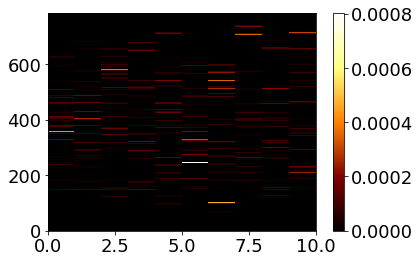

In [404]:
plt.pcolor(np.absolute(Xlas2.T),cmap='afmhot')
plt.colorbar()

From here, we will promote additional sparsity, but not before cross-validation. It should be noted that the matrix $Xlas2$ is now a transposed version of the matrix $X$ that we think of in $AX=B$. Accordingly, columns now correspond to individual pixels, while rows correspond to digit predictions.

We now move on to $k$-fold validation with $k=5,10,20,50$. In particular, we separate the 60000 training samples into $k$ folds consisting of 6000$/k$ samples each; after this, we run the chosen solver (Lasso, $\alpha = 0.5$) on each of the folds individually and average the resulting matrices $X$ entrywise, obtaining 5 matrices $X$ which will be compared before proceeding with the analysis.

In [357]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,ndigits))
X10 = np.zeros((ndigits,npixels))
xsub = np.copy(X10)              #k=10 folds
for jj in range(10):
    asub = A[jj*6000:jj*6000 + 5999,:]    #training images are broken into consecutive blocks of 1000 images
    bsub = B[jj*6000:jj*6000 + 5999,:]    #same for labels
    reg = linear_model.Lasso(alpha=0.5) #same solver as Xlas2 above
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X10 = X10 + xsub                   #all solution matrices xsub of each block are added up
X10 = 0.1*X10                          #subsequently they are divided by k

In [358]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,ndigits))
X20 = np.zeros((ndigits,npixels))
xsub = np.copy(X20)
for jj in range(20):             #k=20 folds
    asub = A[jj*3000:jj*3000 + 2999,:]
    bsub = B[jj*3000:jj*3000 + 2999,:]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X20 = X20 + xsub
X20 = 0.05*X20

In [359]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,ndigits))
X50 = np.zeros((ndigits,npixels))
xsub = np.copy(X50)
for jj in range(50):             #k=50 folds
    asub = A[1*1200:1*1200 + 1199,:]
    bsub = B[1*1200:1*1200 + 1199,:]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X50 = X50 + xsub
X50 = 0.02*X50

In [360]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,ndigits))
X5 = np.zeros((ndigits,npixels))
xsub = np.copy(X5)
for jj in range(5):             #k=5 folds
    asub = A[1*12000:1*12000 + 11999,:]
    bsub = B[1*12000:1*12000 + 11999,:]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5 = X5 + xsub
X5 = 0.2*X5

In [361]:
D10 = np.dot(C,X10.T)    #left-multiply by C to obtain the predictions of the cross-validated Xk
D20 = np.dot(C,X20.T)
D50 = np.dot(C,X50.T)
D5 = np.dot(C,X5.T)

In [362]:
ecross10 = 0 ; ecross20 = 0 ; ecross50 = 0 ; ecross5 = 0 
for jj in range(ntesting):
    if np.argmax(D10[jj,:]) != np.argmax(D[jj,:]):    #test for incorrect indices in Dk
        ecross10 = ecross10 + 1                       #count up error if index of max entry disagrees with correct
    if np.argmax(D20[jj,:]) != np.argmax(D[jj,:]):
        ecross20 = ecross20 + 1
    if np.argmax(D50[jj,:]) != np.argmax(D[jj,:]):
        ecross50 = ecross50 + 1
    if np.argmax(D5[jj,:]) != np.argmax(D[jj,:]):
        ecross5 = ecross5 + 1
eratio = np.array([las2/ntesting , ecross5/ntesting , ecross10/ntesting , ecross20/ntesting , ecross50/ntesting])
print(eratio)               #eratio is vector of fractions of errors so-described in k=1,5,10,20,50 (this order)

[0.2083 0.2061 0.2081 0.2077 0.2109]


It is straightforward to see that the lowest error ratio is obtained by the matrix $\texttt{X5}$ that was obtained by cross-validation with $k=5$ folds.

Now, for the sake of visualization, we illustrate a plot depicting the importance of pixels as weighted by the matrix $\texttt{X5}$, as we did with the matrix $\texttt{Xlas2}$:

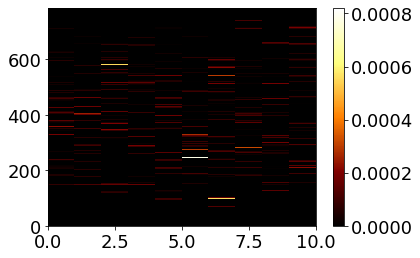

In [405]:
plt.pcolor(np.absolute(X5.T),cmap='afmhot')
plt.colorbar()

Considering this plot and comparing it to that of $\texttt{Xlas2}$, we can see that many of the pixels that are heavily weighted by $\texttt{Xlas2}$ are also heavily weighted by $\texttt{X5}$; this is not only unexpected, but also reassuring, as we are now more assured by the fact that cross-validation has reassured us of the importance of these pixels, while achieving an even lower error ratio with the matrix $\texttt{X5}$. Taking this matrix as our map, we move forward with our analysis.

We now move on to promote additional sparsity, taking only the $m$ ($m$ = 100, 125, 150) highest-$L^1$-norm pixels, augmenting $\texttt{X5}$ accordingly, and comparing these sparse representations for accuracy. For comparison, before we formulate each of these sparse representations, we count the number of nonzero rows in $\texttt{X_5}$.

In [427]:
nonzero = 0

for jj in range(npixels):
    if np.linalg.norm(X5[:,jj],1) != 0:
        nonzero = nonzero + 1
print(nonzero)

383


Knowing now that the matrix $\texttt{X5}$ contains 383 nonzero rows, we move on to construct the matrices $\texttt{Sparse_m}$, each having $m$ nonzero pixels for $m$ = 100, 125, 150

In [363]:
X = np.copy(X5)
bigg = np.array([0])   #bigg will contain the L1-norms of all pixels

for jj in range(npixels):
    y = X[:,jj]
    v = np.array([np.linalg.norm(y,1)])
    bigg = np.vstack((bigg,v))

In [364]:
biggest = np.array([0, 0])      #biggest will keep the indices and L1-norms
for jj in range(150):
    index = np.argmax(bigg)   #index of max
    value = np.max(bigg)      #max itself
    x = np.array([index, value]) #append to biggest
    biggest = np.vstack((biggest,x))  
    bigg[index] = 0           #zero out bigg so as to avoid double-counting largest entry
biggest = np.delete(biggest, 0, 0)   #remove initial row
np.set_printoptions(precision=16,suppress=True)
print(biggest)

[[351.                   0.0010808694875256]
 [377.                   0.0010096711504346]
 [103.                   0.0008434343641433]
 [713.                   0.0007942647476544]
 [249.                   0.0007781254422101]
 [349.                   0.0007702644215454]
 [379.                   0.000734268254758 ]
 [105.                   0.0007259291768528]
 [278.                   0.0006984129791115]
 [544.                   0.0006841883918346]
 [101.                   0.0006620682294253]
 [718.                   0.0006257890792784]
 [720.                   0.0005989196950185]
 [711.                   0.000593506136631 ]
 [584.                   0.0005903166785658]
 [709.                   0.0005901508359071]
 [151.                   0.0005612844896686]
 [402.                   0.000554206924743 ]
 [435.                   0.0005413132669784]
 [213.                   0.0005235328600658]
 [529.                   0.0005057413376102]
 [437.                   0.0005038521724645]
 [268.    

The above matrix includes in the left column the indices of the highest-weight pixels in the representation $X10$ of the images-to-labels map. The right column is comprised of the actual weights (in $L^1$-norm) of these pixels; note that after the 2 heaviest pixels, the $L^1$-norms drop to $\mathcal{O}(10^{-4})$. That's already pretty tiny. At any rate, we move on and construct our sparse modifications of $\texttt{X5}$:

In [365]:
Sparse_100 = np.zeros((ndigits,npixels)) #start with matrix of zeros
for jj in range(100):
    k =  biggest[jj,0]     
    k = int(k)
    Sparse_100[:,k] = X[:,k]             #fill in with the appropriate pixel weights (note: pixel weights are in cols)
    
Dee_100 = np.dot(C,Sparse_100.T)    #record predictions from top 100, transposing appropriately

In [366]:
Sparse_125 = np.zeros((ndigits,npixels))
for jj in range(125):
    k =  biggest[jj,0]
    k = int(k)
    Sparse_125[:,k] = X[:,k]
    
Dee_125 = np.dot(C,Sparse_125.T)    #record predictions from top 125

In [367]:
Sparse_150 = np.zeros((ndigits,npixels))
for jj in range(150):
    k =  biggest[jj,0]
    k = int(k)
    Sparse_150[:,k] = X[:,k]
    
Dee_150 = np.dot(C,Sparse_150.T)    ##record predictions from top 150

In [368]:
errors = 0
for jj in range(ntesting):
    if np.argmax(Dee_100[jj,:]) != np.argmax(D[jj,:]):  #this is now our preferred measure of error
        errors = errors + 1                             #index of max in prediction vs index of correct digit
eratio_100 = errors/ntesting
print(eratio_100)            #ratio of errors after accounting for only 100 heaviest pixels

0.5105


In [369]:
errors = 0
for jj in range(ntesting):
    if np.argmax(Dee_125[jj,:]) != np.argmax(D[jj,:]):
        errors = errors + 1
eratio_125 = errors/ntesting
print(eratio_125)             #ratio of errors after accounting for only 125 heaviest pixels

0.4287


In [370]:
errors = 0
for jj in range(ntesting):
    if np.argmax(Dee_150[jj,:]) != np.argmax(D[jj,:]):
        errors = errors + 1
eratio_150 = errors/ntesting
print(eratio_150)             #ratio of errors after accounting for only 150 heaviest pixels

0.3785


As we can see, after promoting sparsity by considering only the 150 most-important pixels in the image, our error ratio ($\texttt{eratio_150}$ above) has grown, but we still maintain 38% failure, i.e. 62% accuracy, in our prediction on the test set. Compare this with the value obtained from the non-cross-validated $\texttt{Xlas2}$:

In [371]:
X = np.copy(Xlas2)
bigg = np.array([0])   #bigg will contain the L1-norms of all pixels

for jj in range(npixels):
    y = X[:,jj]
    v = np.array([np.linalg.norm(y,1)])
    bigg = np.vstack((bigg,v))

In [372]:
biggest = np.array([0, 0])      #biggest will keep the indices and L1-norms
for jj in range(150):
    index = np.argmax(bigg)   #index of max
    value = np.max(bigg)      #max itself
    x = np.array([index, value]) #append to biggest
    biggest = np.vstack((biggest,x))  
    bigg[index] = 0           #zero out bigg so as to avoid double-counting largest entry
biggest = np.delete(biggest, 0, 0)   #remove initial row
np.set_printoptions(precision=16,suppress=True)

In [373]:
Sparse150 = np.zeros((ndigits,npixels))
for jj in range(150):
    k =  biggest[jj,0]
    k = int(k)
    Sparse150[:,k] = X[:,k]
    
Dee150 = np.dot(C,Sparse150.T)    #record predictions from top 150 using Xlas2

In [374]:
errors = 0
for jj in range(ntesting):
    if np.argmax(Dee150[jj,:]) != np.argmax(D[jj,:]):
        errors = errors + 1
eratio150 = errors/ntesting
print(eratio150)             #ratio of errors after accounting for only 150 heaviest pixels using Xlas2

0.3303


Note that now we have seen a 67% success rate of prediction with the heaviest 150 pixels of $\texttt{Xlas2}$ while we have seen only a 62% success rate of prediction with the 10-fold cross-validated version of $\texttt{X10}$. I do not know why this would be the case, but it is worth noting. Perhaps some artifact of the ordering of samples has emerged as a stick in the spokes of our cross-validation. At any rate, while we discuss the promoted spartisy of $\texttt{Sparse_150}$ over that of $\texttt{X5}$, it is worth also considering the heat-map plot of the entries of $\texttt{Sparse_150}$; as such, the plot of this matrix's weights is produced below.

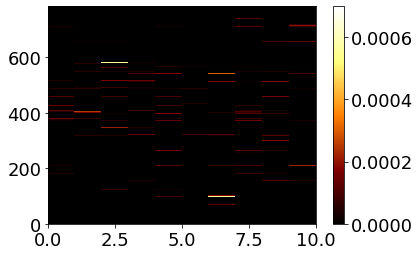

In [406]:
plt.pcolor(np.absolute(Sparse_150.T),cmap='afmhot')
plt.colorbar()

Examining the brightest entries of the above matrix and comparing it to the analogous plots of $\texttt{Xlas2}$ and $\texttt{X5}$, it is perhaps clearer to see which pixels matter most in distinguishing digits.

We now re-do the above with digit-wise analysis, identifying the most important pixels for distinguishing each digit and creating a corresponding sparse matrix. This process is carried out in two ways. First, we take the matrix $\texttt{X5}$ and find the 100 heaviest pixels in the column associated to each digit; second, we re-start the analysis, training again to decide the yes/no answer to "Is this image a picture of digit $k$?" for every $k$. These two methods are compared in terms of error.

In [375]:
dummy = np.copy(X5)           #dummy proxies X5 to avoid messing with our map
biggestp = np.zeros((1,ndigits))    #will store rankings of important pixels for each digit
v = np.zeros((1,ndigits))
for ii in range(100):           #as opposed to previous pixel ranking, we now consider top 100 pixels
    for jj in range(ndigits):   #for each of the 10 digits individually
        digit = dummy[jj,:]        #digit takes the jth column of X10 when we are considering digit j
        index = np.argmax(digit)   #find the index of the heaviest digit in this column
        v[0,jj] = index           #v stores the index of this digit 
        dummy[jj,index] = 0       #set this entry of x10 proxy to 0
    biggestp = np.vstack((biggestp,v))          #take heaviest for each pixel, then 2nd heaviest for each pixel, etc.
biggestp = np.delete(biggestp, 0, 0)        
print(biggestp)

[[386. 350. 583. 564. 427. 248. 102. 708. 376. 719.]
 [359. 378. 528. 322. 425. 277. 104. 710. 348. 717.]
 [330. 434. 509. 376. 399. 191. 100. 741. 405. 712.]
 [387. 406. 124. 151. 426. 220.  70. 743. 656. 210.]
 [428. 462. 555. 592. 437. 192. 543. 284. 514. 212.]
 [300. 322. 518. 150. 431. 276. 415. 737. 657. 211.]
 [481. 517. 610. 176. 374. 162.  69. 712. 302. 716.]
 [301. 295. 150. 409. 400. 609.  99. 265. 658. 401.]
 [627. 160. 539. 323. 439. 188. 572. 235. 460. 718.]
 [240. 405. 581. 650. 464. 346.  68. 257. 433. 382.]
 [271. 490. 541. 683. 346. 348.  72. 232. 303. 715.]
 [629. 267. 609. 653. 490. 189. 514. 268. 327. 213.]
 [210. 294. 516. 468. 191. 376. 103. 267. 301. 371.]
 [401. 489. 538. 380. 373. 190. 601. 326. 662. 711.]
 [510. 461. 459. 296. 460. 305.  71. 739. 487. 370.]
 [270. 660. 492. 466. 353. 347. 470. 740. 488. 710.]
 [512. 433. 595. 497. 428. 291. 574. 266. 541. 237.]
 [155. 545. 565. 622. 438. 344. 375. 296. 157. 459.]
 [427. 659. 564. 181. 463. 206. 515. 713. 320.

In [378]:
Sparsedig = np.zeros((ndigits,npixels))  #Sparsedig will be our new sparse X5 
                                         #keeping the 15 most important pixels for each digit
for ii in range(ndigits):    
    for jj in range(15):
        k =  biggestp[jj,ii]             #include the weights of the 15 most important pixels in each row
        k = int(k)                     
        Sparsedig[ii,k] = X5[ii,k]        #put them into Sparsedig
    
Deedig = np.dot(C,Sparsedig.T)           #Deedig contains predictions of Sparsedig

In [379]:
nonzero = 0
for jj in range(ndigits):
    for ii in range(npixels):
        if Sparsedig[jj,ii] != 0:        #note: Sparsedig has 15 nonzero entries of most important pixels
            nonzero = nonzero + 1        #in each of the 10 columns
print(nonzero)                           #i.e. Sparsedig has 150 nonzero entries, i.e.\leq 150 pixels considered

150


Now that we have our sparse map $\texttt{Sparsedig}$, we can evaluate the error incurred in using this for prediction. At this stage, we must formulate a new version of error, seeing as $\texttt{Sparsedig}$ is now deciding a yes/no of whether a given digit is appeared, rather than picking a "most-probably-depicted" digit.

In [412]:
dig_error = np.zeros((1, ndigits))   
              #dig_error will hold the number of "error" entries for one digit in each of 10 entries
             #if Deedig assigns a value \geq 0.5 to a given image in a given column, Deedig sais "yes" to the digit
for jj in range(ntesting):
    for ii in range(ndigits):
        if np.absolute(Deedig[jj,ii] - D[jj,ii]) > 0.5:  #if Deedig is off by more than 0.5, it must have chosen wrong
            dig_error[0,ii] = dig_error[0,ii] + 1
dig_erat = (1/ntesting)*dig_error
print(dig_erat)

[[0.0954 0.071  0.1    0.101  0.0979 0.0889 0.0851 0.1016 0.0874 0.1002]]


By looking at the above vector, we now see that $\texttt{Sparsedig}$ has an error rate of around 10% in distinguishing each individual digit! This is a good performance. We can again consider a heat-map prediction of the sparse matrix $\texttt{Sparsedig}$ representing our images-labels map:

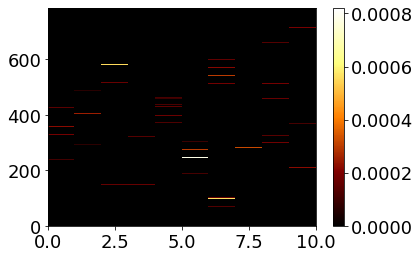

In [407]:
plt.pcolor(np.absolute(Sparsedig.T),cmap='afmhot')
plt.colorbar()

Finally, we now proceed to the second method of identifying a map from labels to images based on observing only individual digits. In particular, in the section below we re-start the above process, training and cross-validating once more, for each individual digit. Doing so produces individually specialized vectors $\texttt{X5_k}$, respectively tuned to determine whether or not the input image depicts the digit $k$.once these vectors are obtained, they are placed into a single matrix $\texttt{Xsingle}$. Once this matrix is obtained, it is thinned out to contain only the 15 most-important pixels as nonzero entries in columns, via a process identical to that producing $\texttt{Sparsedig}$ above; this sparse matrix is named $\texttt{Sparse_single}$. Lastly, prediction matrices $\texttt{Dsingle}$ and $\texttt{Deesingle}$, corresponding to $\texttt{Xsingle}$ and $\texttt{Sparse_single}$ respectively, are then evaluated and analyzed just as $\texttt{Deedig}$ is above.

In [120]:
b0 = B[:,0] ; d0 = D[:,0]
b1 = B[:,1] ; d1 = D[:,1]      #vectors bk correspond to the training labels for digit k
b2 = B[:,2] ; d2 = D[:,2]      #bk[jj] =  1 iff image jj depicts k
b3 = B[:,3] ; d3 = D[:,3]      #the same is done for dk
b4 = B[:,4] ; d4 = D[:,4]
b5 = B[:,5] ; d5 = D[:,5]
b6 = B[:,6] ; d6 = D[:,6]
b7 = B[:,7] ; d7 = D[:,7]
b8 = B[:,8] ; d8 = D[:,8]
b9 = B[:,9] ; d9 = D[:,9]

In [133]:
Xdigits = np.zeros((npixels,ndigits))       #Xdigits is the matrix to be filled with digit-wise weights as columns

In [383]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_0 = np.zeros((npixels))
xsub = np.copy(X5_0)                        #training and cross-validation
for jj in range(5):                         #we again perform 5-fold cross-validation
    asub = A[jj*12000:jj*12000 + 11999,:]      
    bsub = B[jj*12000:jj*12000 + 11999,0]
    reg = linear_model.Lasso(alpha=0.5)     #again we use Lasso with alpha = 0.5
    reg.fit(asub,bsub)             #solution vectors here are therefore produced in complete analogy with X5
    xsub = reg.coef_                        
    X5_0 = X5_0 + xsub
X5_0 = 0.2*X5_0                    #X5_0 is vector of weights for deciding whether 0 is depicted

In [384]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_1 = np.zeros((npixels))
xsub = np.copy(X5_1)                        #identical process as above, determining now X5_1 for digit 1
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,1]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_1 = X5_1 + xsub
X5_1 = 0.2*X5_1

In [385]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_2 = np.zeros((npixels))
xsub = np.copy(X5_2)                        #identical process as above, determining now X5_1 for digit 2
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,2]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_2 = X5_2 + xsub
X5_2 = 0.2*X5_2

In [386]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_3 = np.zeros((npixels))
xsub = np.copy(X5_3)                        #identical process as above, determining now X5_1 for digit 3
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,3]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_3 = X5_3 + xsub
X5_3 = 0.2*X5_3

In [387]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_4 = np.zeros((npixels))
xsub = np.copy(X5_4)                        #identical process as above, determining now X5_1 for digit 4
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,4]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_4 = X5_4 + xsub
X5_4 = 0.2*X5_4

In [388]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_5 = np.zeros((npixels))
xsub = np.copy(X5_5)                        #identical process as above, determining now X5_1 for digit 5
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,5]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_5 = X5_5 + xsub
X5_5 = 0.2*X5_5

In [389]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_6 = np.zeros((npixels))
xsub = np.copy(X5_6)                        #identical process as above, determining now X5_1 for digit 6
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,6]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_6 = X5_6 + xsub
X5_6 = 0.2*X5_6

In [390]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_7 = np.zeros((npixels))
xsub = np.copy(X5_7)                        #identical process as above, determining now X5_1 for digit 7
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,7]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_7 = X5_7 + xsub
X5_7 = 0.2*X5_7

In [391]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_8 = np.zeros((npixels))
xsub = np.copy(X5_8)                        #identical process as above, determining now X5_1 for digit 8
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,8]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_8 = X5_8 + xsub
X5_8 = 0.2*X5_8

In [392]:
asub = np.zeros((100,npixels))
bsub = np.zeros((100,1))
X5_9 = np.zeros((npixels))
xsub = np.copy(X5_9)                        #identical process as above, determining now X5_1 for digit 9
for jj in range(5):
    asub = A[jj*12000:jj*12000 + 11999,:]
    bsub = B[jj*12000:jj*12000 + 11999,9]
    reg = linear_model.Lasso(alpha=0.5)
    reg.fit(asub,bsub)
    xsub = reg.coef_
    X5_9 = X5_9 + xsub
X5_9 = 0.2*X5_9

In [394]:
Dsingle = np.zeros((ntesting,ndigits))
Dsingle[:,0] = np.dot(C,X5_0)
Dsingle[:,1] = np.dot(C,X5_1)
Dsingle[:,2] = np.dot(C,X5_2)
Dsingle[:,3] = np.dot(C,X5_3)              #Dsingle is now constructed column-wise 
Dsingle[:,4] = np.dot(C,X5_4)              #kth col of Dsingle contains predictions of X5_k on test data
Dsingle[:,5] = np.dot(C,X5_5)
Dsingle[:,6] = np.dot(C,X5_6)
Dsingle[:,7] = np.dot(C,X5_7)
Dsingle[:,8] = np.dot(C,X5_8)
Dsingle[:,9] = np.dot(C,X5_9)

In [410]:
dig_errors = np.zeros((1, ndigits))   
              #dig_errors will hold the number of "error" entries for one digit in each of 10 entries
             #if Dsingle assigns a value \geq 0.5 to a given image in a given column, Deedig sais "yes" to the digit
for jj in range(ntesting):
    for ii in range(ndigits):
        if np.absolute(Dsingle[jj,ii] - D[jj,ii]) > 0.5:  #if Dsingle is off by more than 0.5, it has chosen wrong
            dig_errors[0,ii] = dig_errors[0,ii] + 1
dig_eratio = (1/ntesting)*dig_errors
print(dig_eratio)

[[0.0397 0.0623 0.0547 0.0529 0.0833 0.0817 0.0377 0.0642 0.0455 0.0818]]


The above vector contains the fraction of errors incurred by each of the individual maps $\texttt{X5_k}$; clearly, the re-trained digit-wise maps perform better than the columns of $\texttt{Sparsedig}$ above, as here we see roughly 6% error rate for each digit individually. However, this improvement should be taken with a grain of salt, as $\texttt{Sparsedig}$ consisted of only the 15 most important pixels in each digit prediction. To level the playing field, we now perform the same process for the $\texttt{X5_k}$ and re-evaluate.

In [397]:
Xsingle = np.zeros((ndigits,npixels))    #for technical convenience, combine X5_k vect into Xsingle matrix
Xsingle[0,:] = X5_0
Xsingle[1,:] = X5_1
Xsingle[2,:] = X5_2
Xsingle[3,:] = X5_3
Xsingle[4,:] = X5_4
Xsingle[5,:] = X5_5
Xsingle[6,:] = X5_6
Xsingle[7,:] = X5_7
Xsingle[8,:] = X5_8
Xsingle[9,:] = X5_9

In [398]:
dummy = np.copy(Xsingle)           #dummy proxies X5 to avoid messing with our map
biggestp = np.zeros((1,ndigits))    #will store rankings of important pixels for each digit
v = np.zeros((1,ndigits))
for ii in range(100):           #as opposed to previous pixel ranking, we now consider top 100 pixels
    for jj in range(ndigits):   #for each of the 10 digits individually
        digit = dummy[jj,:]        #digit takes the jth column of X10 when we are considering digit j
        index = np.argmax(digit)   #find the index of the heaviest digit in this column
        v[0,jj] = index           #v stores the index of this digit 
        dummy[jj,index] = 0       #set this entry of x10 proxy to 0
    biggestp = np.vstack((biggestp,v))          #take heaviest for each pixel, then 2nd heaviest for each pixel, etc.
biggestp = np.delete(biggestp, 0, 0)        
print(biggestp)

[[359. 350. 528. 564. 426. 248. 102. 708. 657. 718.]
 [386. 378. 583. 323. 428. 220. 103. 741. 348. 719.]
 [300. 406. 555. 376. 427. 191. 104. 709. 514. 717.]
 [413. 434. 609. 409. 463. 277.  70. 739. 376. 716.]
 [330. 322. 556. 651. 439. 276.  72. 711. 656. 212.]
 [329. 462. 610. 176. 374. 192. 101. 743. 541. 210.]
 [358. 489. 124. 151. 460. 249. 543. 715. 275. 211.]
 [429. 517. 518. 350. 464. 162. 514. 284. 433. 712.]
 [511. 295. 517. 150. 425. 190.  99. 738. 515. 713.]
 [387. 294. 149. 650. 431. 348. 572. 266. 460. 720.]
 [627. 405. 509. 497. 400. 188.  69. 712. 302. 714.]
 [401. 433. 580. 466. 490. 189. 100. 742. 487. 409.]
 [482. 159. 151. 653. 398. 376. 414. 713. 488. 715.]
 [240. 461. 566. 296. 353. 597. 375. 267. 319. 379.]
 [271. 267. 491. 322. 437. 161. 576. 264. 320. 370.]
 [512. 545. 569. 152. 325. 315. 602. 268. 659. 355.]
 [454. 266. 539. 680. 399. 347. 415. 714. 327. 213.]
 [629. 490. 611. 178. 373. 567. 486. 710. 658. 464.]
 [427. 323. 519. 655. 462. 319. 573. 265. 157.

In [399]:
Sparse_single = np.zeros((ndigits,npixels))  #Sparse_single will be our new sparse X5 
                                         #keeping the 15 most important pixels for each digit
for ii in range(ndigits):    
    for jj in range(15):
        k =  biggestp[jj,ii]             #include the weights of the 15 most important pixels in each row
        k = int(k)                     
        Sparse_single[ii,k] = X5[ii,k]        #put them into Sparse_single
    
Deesingle = np.dot(C,Sparse_single.T)  

In [409]:
dig_errorss = np.zeros((1, ndigits))   
              #dig_errors will hold the number of "error" entries for one digit in each of 10 entries
             #if Deesingle assigns a value \geq 0.5 to a given image in a given column, Deesingle sais "yes" to the digit
for jj in range(ntesting):
    for ii in range(ndigits):
        if np.absolute(Deesingle[jj,ii] - D[jj,ii]) > 0.5:  #if Deesingle is off by more than 0.5, it must have chosen wrong
            dig_errorss[0,ii] = dig_errorss[0,ii] + 1
dig_eratios = (1/ntesting)*dig_errorss
print(dig_eratios)

[[0.098  0.0678 0.1032 0.101  0.0982 0.0892 0.0838 0.1028 0.0928 0.1012]]


In [411]:
print(dig_eratio) 

[[0.0397 0.0623 0.0547 0.0529 0.0833 0.0817 0.0377 0.0642 0.0455 0.0818]]


In [413]:
print(dig_erat)

[[0.0954 0.071  0.1    0.101  0.0979 0.0889 0.0851 0.1016 0.0874 0.1002]]


Now, comparing the error ratios incurred by $\texttt{Sparsedig}$ and $\texttt{Sparse_single}$, it is clear to see that the performance of the two is nearly identical; that is, if sparsity is mandated, it does not matter whether or not we retrained on single digits. The cross-validated Lasso procedure therefore produces comparable errors up to the 15 most-important pixels when considered as evaluating whether individual digits are produced. For the sake of completeness, below we also consider the heat-map depictions of the matrices $\texttt{Xsingle}$ and $\texttt{Sparse_single}$ produced by digit-wise retraining and subsequent sparsity enforcement.

At this stage, we turn our attention to plots for the sake of visualization. In the above body of the notebook, we have been neglecting plots; this is because during the writing of the notebook, I did all of my plotting In the section below. 

Text(0.5, 0, 'Sparse_single')

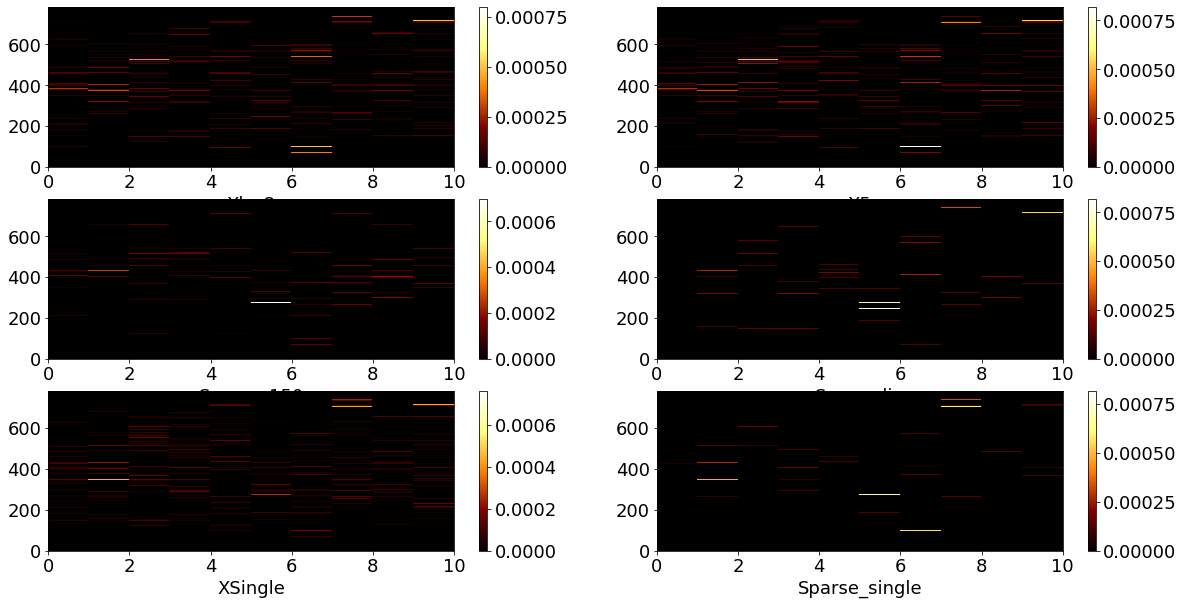

In [430]:
#Here we consider the relative sparsity patterns of the six matrices Xlas2, X5, Sparse_150, Sparsedig, Xsingle, and Sparse_single
#it is clear from the plots that all six of these maps place relatively similar importance on many of the highest-ranking pixels


plt.rcParams['figure.figsize'] = [20, 10]

fig,axs = plt.subplots(3,2)

x_pcolor = axs[0,0].pcolor(np.absolute(Xlas2.T),cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[0,0])
axs[0,0].set_xlabel('Xlas2')


x_pcolor = axs[0,1].pcolor(np.absolute(X5.T),cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[0,1])
axs[0,1].set_xlabel('X5')


x_pcolor = axs[1,0].pcolor(np.absolute(Sparse_150.T),cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[1,0])
axs[1,0].set_xlabel('Sparse_150')


x_pcolor = axs[1,1].pcolor(Sparsedig.T,cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[1,1])
axs[1,1].set_xlabel('Sparsedig')


x_pcolor = axs[2,0].pcolor(np.absolute(Xsingle.T),cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[2,0])
axs[2,0].set_xlabel('XSingle')


x_pcolor = axs[2,1].pcolor(Sparse_single.T,cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[2,1])
axs[2,1].set_xlabel('Sparse_single')


Text(0.5, 0, 'Sparse_150')

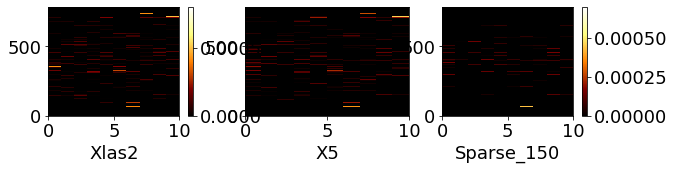

In [458]:
#this is one of the plots included in the report, constructed explicitly for the purpose of including in the report

plt.rcParams['figure.figsize'] = [12, 10]

fig,axs = plt.subplots(1,3)

x_pcolor = axs[0].pcolor(np.absolute(Xlas2.T),cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[0])
axs[0].set_xlabel('Xlas2')


x_pcolor = axs[1].pcolor(np.absolute(X5.T),cmap='afmhot')
#fig.colorbar(x_pcolor, ax=axs[1])
axs[1].set_xlabel('X5')


x_pcolor = axs[2].pcolor(np.absolute(Sparse_150.T),cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[2])
axs[2].set_xlabel('Sparse_150')


Text(0.5, 0, 'Sparse_single')

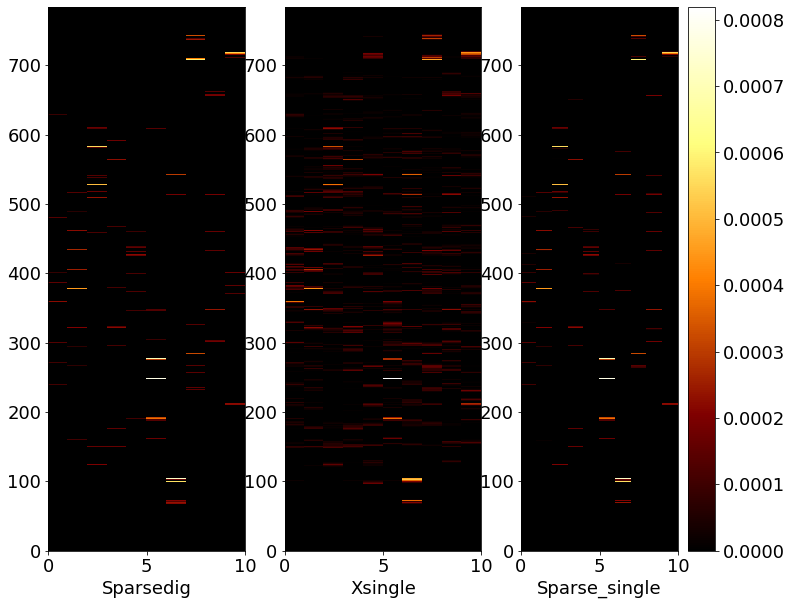

In [461]:
#this is one of the plots included in the report, constructed explicitly for the purpose of including in the report

plt.rcParams['figure.figsize'] = [12, 10]

fig,axs = plt.subplots(1,3)

x_pcolor = axs[0].pcolor(np.absolute(Sparsedig.T),cmap='afmhot')
#fig.colorbar(x_pcolor, ax=axs[0])
axs[0].set_xlabel('Sparsedig')


x_pcolor = axs[1].pcolor(np.absolute(Xsingle.T),cmap='afmhot')
#fig.colorbar(x_pcolor, ax=axs[1])
axs[1].set_xlabel('Xsingle')


x_pcolor = axs[2].pcolor(np.absolute(Sparse_single.T),cmap='afmhot')
fig.colorbar(x_pcolor, ax=axs[2])
axs[2].set_xlabel('Sparse_single')

In [447]:
allpix = np.zeros((10))    #Here, we construct the vectors used in constructing the histograms included in the report
top15 = np.zeros((10))
fromx5 = np.zeros((10))
for ii in range(10):
    fromx5[ii] = dig_erat[0,ii]
    allpix[ii] = dig_eratio[0,ii]
    top15[ii] = dig_eratios[0,ii]

(0.025, 0.15)

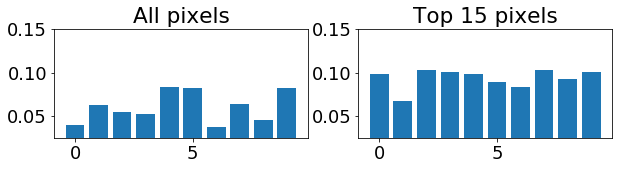

In [457]:
plt.rcParams['figure.figsize'] = [10, 2]   #explanations of these plots are included in the report
  
fig,axs = plt.subplots(1,2)

axs[0].bar(range(10),allpix)
axs[0].set_title('All pixels')
axs[0].set_ylim((0.025,0.15))
axs[1].bar(range(10),top15)
axs[1].set_title('Top 15 pixels')
axs[1].set_ylim((0.025,0.15))


(0.025, 0.15)

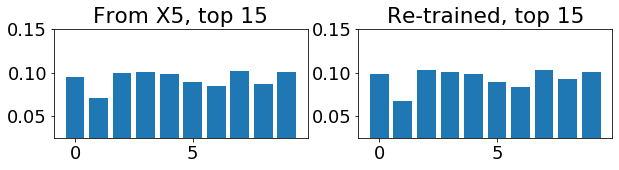

In [456]:
plt.rcParams['figure.figsize'] = [10, 2]   #explanations of these plots are included in the report

fig,axs = plt.subplots(1,2)

axs[0].bar(range(10),fromx5)
axs[0].set_title('From X5, top 15')
axs[0].set_ylim((0.025,0.15))
axs[1].bar(range(10),top15)
axs[1].set_title('Re-trained, top 15')
axs[1].set_ylim((0.025,0.15))